# Importing Libraries and Dataset preparation

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,InputLayer,BatchNormalization,Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
dataset , dataset_info = tfds.load('malaria',with_info = True,as_supervised = True,shuffle_files=True,split=["train"])

In [5]:
for data in dataset[0].take(4):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(115, 157, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [6]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
  
  return train_dataset, val_dataset, test_dataset


In [7]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset,val_dataset,test_dataset = splits(dataset[0] , TRAIN_RATIO , VAL_RATIO , TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),
      list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

# Data visualization

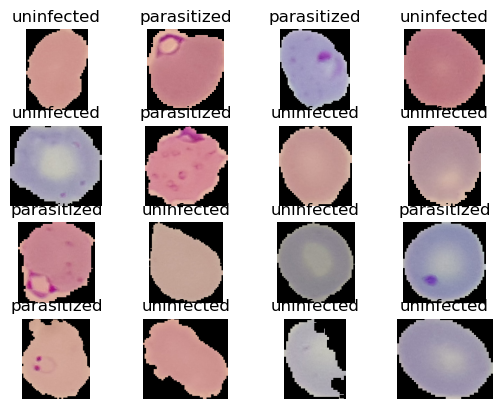

In [8]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

plt.show()

# Data Preprocessing 

In [9]:
IM_SIZE = 224
def resize_rescale(image,label):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0,label

In [10]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [11]:
for image,label in  train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [12]:
BATCH_SIZE = 32
train_dataset =train_dataset.shuffle(buffer_size = 8 , reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [14]:
BATCH_SIZE = 32
val_dataset =val_dataset.shuffle(buffer_size = 8 , reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [16]:
test_dataset = test_dataset.batch(1)

In [17]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Model Creation

## Sequential API

In [18]:
model = tf.keras.Sequential([
                              InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),

                              Conv2D(filters = 6,kernel_size = 3,strides = 1,padding='valid',activation = 'relu'),
                              BatchNormalization(),
                              MaxPool2D(pool_size=2,strides=2,),

                              Conv2D(filters = 16,kernel_size = 3,strides = 1,padding='valid',activation = 'relu'),
                              BatchNormalization(),
                              MaxPool2D(pool_size=2,strides=2,),

                              Flatten(),

                              Dense(100,activation = 'relu'),
                              BatchNormalization(),
                              Dense(10,activation = 'relu'),
                              BatchNormalization(),
                              Dense(1,activation = 'sigmoid')



])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

## Functional API

### Feature Extraction with two cells doing the same thing

In [24]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D (pool_size = 2, strides= 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D (pool_size = 2, strides= 2)(x)

feature_extractor_model = Model(func_input, output, name = "Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_12 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_13 (Ba  (None, 109, 109, 16)

In [25]:

func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D (pool_size = 2, strides= 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D (pool_size = 2, strides= 2)(x)

feature_extractor_model = Model(func_input, output, name = "Feature_Extractor")
feature_extractor_model.summary()


Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_14 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_15 (Ba  (None, 109, 109, 16)

### Callable Model

In [26]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

X = feature_extractor_seq_model(func_input)
X = Flatten()(X)

X = Dense(100,activation = 'relu')(X)
X = BatchNormalization()(X)

X = Dense(10,activation = 'relu')(X)
X = BatchNormalization()(X)

func_output = Dense(1,activation = 'sigmoid')(X)

lenet_model_func = Model(func_input,func_output,name = 'Lenet_Model')
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_3 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_16 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                1010      
                                                       

## Model Subclassing

In [35]:
class FeatureExtractor(Layer):
    def __init__(self,filters,kernel_size,strides,padding,activation,pool_size):
        super(FeatureExtractor, self).__init__()
        
        self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides =strides, padding = padding, activation=activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D (pool_size=pool_size , strides=2*strides)
        
        self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides =strides, padding = padding, activation=activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D (pool_size=pool_size, strides=2*strides)
        
    def call(self,x,training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x) 
        
        x = self.conv_2(x) 
        x = self.batch_2(x)  
        x = self.pool_2(x) 
        return x 
feature_sub_classed = FeatureExtractor(8,3,1,"valid","relu",2)

In [36]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

X = feature_sub_classed(func_input)
X = Flatten()(X)

X = Dense(100,activation = 'relu')(X)
X = BatchNormalization()(X)

X = Dense(10,activation = 'relu')(X)
X = BatchNormalization()(X)

func_output = Dense(1,activation = 'sigmoid')(X)

lenet_model_func = Model(func_input,func_output,name = 'Lenet_Model')
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor_3 (Featu  (None, 54, 54, 16)        1488      
 reExtractor)                                                    
                                                                 
 flatten_5 (Flatten)         (None, 46656)             0         
                                                                 
 dense_12 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_26 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            (None, 10)                

# Model Compilation and Training

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.1),loss=BinaryCrossentropy(),metrics="accuracy")

In [ ]:
history = model.fit(train_dataset,epochs=100,verbose=1)

Epoch 1/100


2023-10-30 20:54:56.594366: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


689/689 [==============================] - 102s 132ms/step - loss: 0.6295 - accuracy: 0.6588
Epoch 2/100
689/689 [==============================] - 87s 126ms/step - loss: 0.5795 - accuracy: 0.7461
Epoch 3/100
689/689 [==============================] - 96s 139ms/step - loss: 0.4081 - accuracy: 0.8749
Epoch 4/100
689/689 [==============================] - 83s 120ms/step - loss: 0.3514 - accuracy: 0.8984
Epoch 5/100
689/689 [==============================] - 76s 111ms/step - loss: 0.3025 - accuracy: 0.9076
Epoch 6/100
689/689 [==============================] - 75s 109ms/step - loss: 0.2919 - accuracy: 0.9118
Epoch 7/100
227/689 [========>.....................] - ETA: 53s - loss: 0.2880 - accuracy: 0.9156

KeyboardInterrupt: 

# Model Evaluation and Testing

In [ ]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 33s 10ms/step - loss: 0.4772 - accuracy: 0.8411


[0.4772130846977234, 0.8411316871643066]

In [ ]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 3s 3s/step


'U'

In [ ]:
def parasite_or_not(x):
    if x<0.5:
        return str("P")
    else:
        return str("U")